# Control runs

In [1]:
import importlib

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client

from modules import stats
importlib.reload(stats)

<module 'modules.stats' from '/srv/ccrc/AtmSS/z5310829/honours_project/modules/stats.py'>

In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38415,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:38395,Total threads: 1
Dashboard: http://127.0.0.1:41157/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:44823,


## Uncertainty estimation

### Data
- $N_x, N_z, \Gamma = 1024, 192, 8$
- $\Delta t = 0.0016$
- Simulation time 300 units
- Initial condition: interpolated from 256 x 128 after 1000 time unit spin-up
- Output frequency: 0.2 time units
- $\mathrm{Ra} = 10^9$
- $\mathrm{Pr} = 1$
- Hyperdiffusivity $\nu^* = 10^{-3}$

In [4]:
data = xr.open_mfdataset('../data/control/1024_192/*.nc')
rayleigh = 1e9
prandtl = 1

### Nusselt number

In [8]:
nusselt = stats.nusselt_number(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

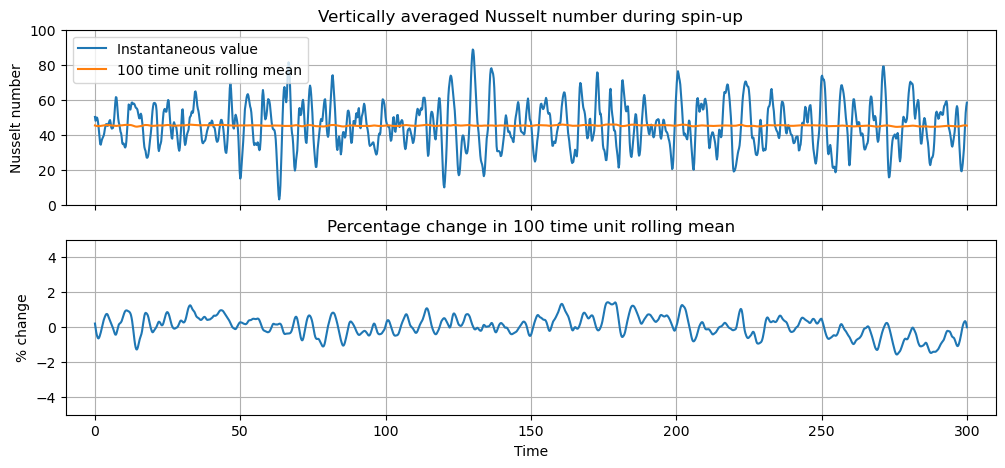

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = nusselt.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(nusselt.t, nusselt, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend()
axes[0].set(
    ylim=(0, 100), xlim=(-10, 310), ylabel='Nusselt number',
    title='Vertically averaged Nusselt number during spin-up'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

### RMS speed

In [11]:
rms_speed = stats.rms_speed(data).compute()

[Text(0, 0.5, '% change')]

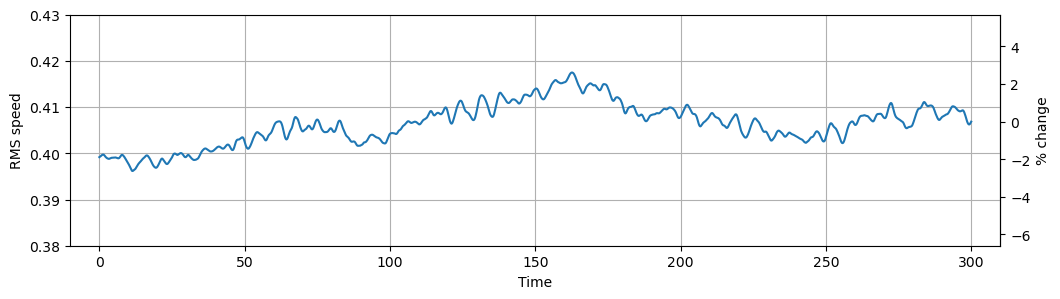

In [12]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(rms_speed.t, rms_speed)
ax.grid()
ax.set(ylim=(0.38, 0.43), xlim=(-10, 310), ylabel='RMS speed', xlabel='Time')

ref = rms_speed.isel(t=-1).item()
sec_ax = ax.secondary_yaxis(
    'right',
    functions=(lambda x: (x/ref - 1)*1e2, lambda x: (x/1e2 + 1)*ref),
)
sec_ax.set(ylabel=r'% change')

### Kinetic energy dissipation rate

In [13]:
eps_k = stats.kinetic_dissipation(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

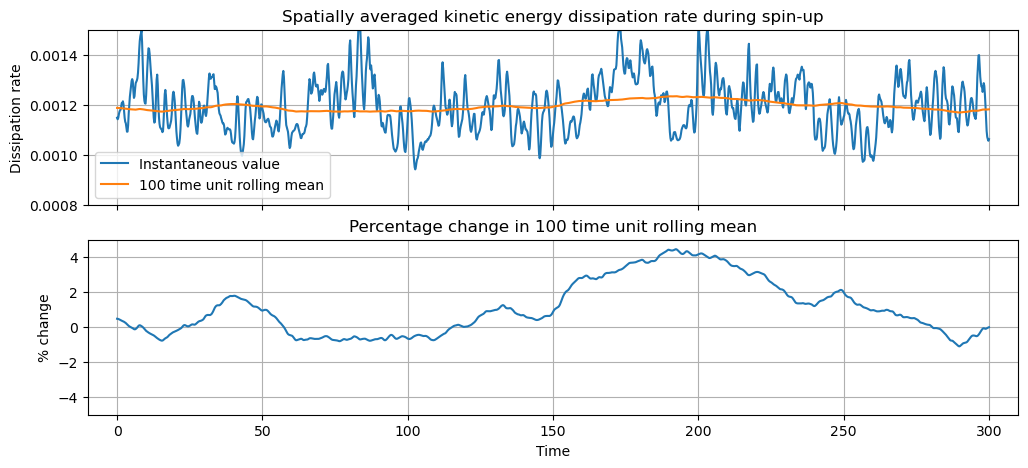

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = eps_k.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(eps_k.t, eps_k, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend()
axes[0].set(
    ylim=(0.8e-3, 1.5e-3), xlim=(-10, 310), ylabel='Dissipation rate',
    title='Spatially averaged kinetic energy dissipation rate during spin-up'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

### Thermal energy dissipation rate

In [15]:
eps_T = stats.thermal_dissipation(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

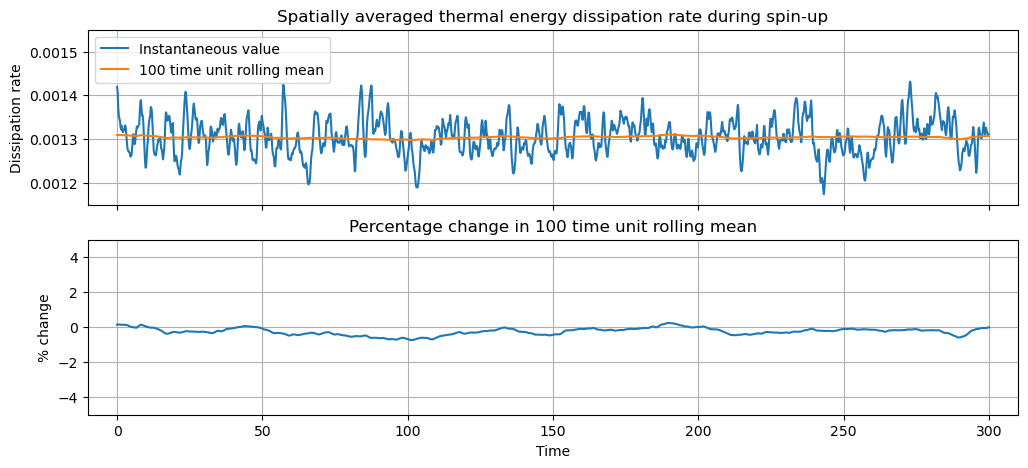

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = eps_T.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(eps_T.t, eps_T, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend(loc='upper left')
axes[0].set(
    ylim=(1.15e-3, 1.55e-3), xlim=(-10, 310), ylabel='Dissipation rate',
    title='Spatially averaged thermal energy dissipation rate during spin-up'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

### Estimating required simulation time

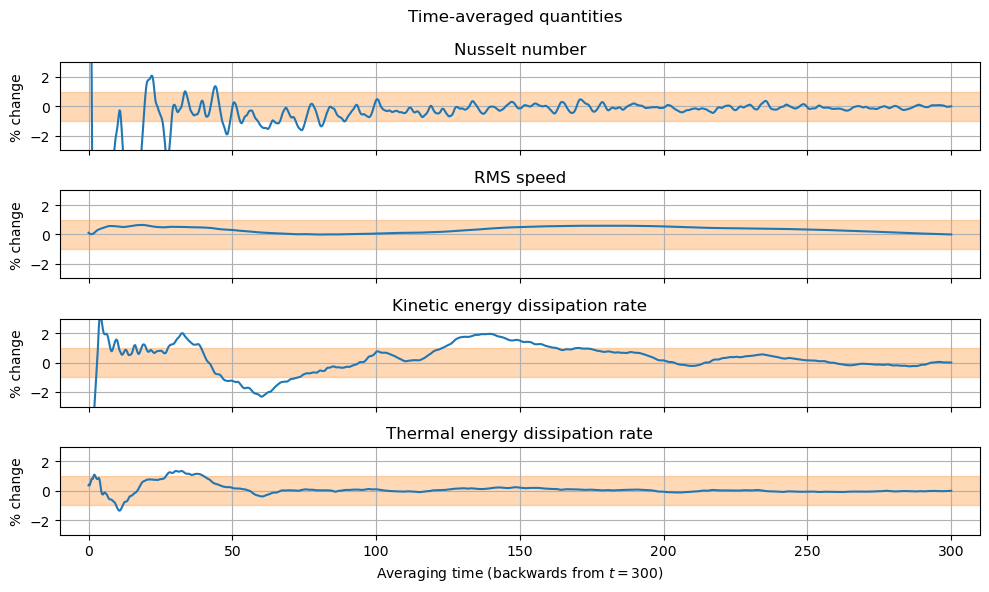

In [17]:
t_max = 300.
metrics = {
    'Nusselt number': nusselt,
    'RMS speed': rms_speed,
    'Kinetic energy dissipation rate': eps_k,
    'Thermal energy dissipation rate': eps_T,
}
fig, axes = plt.subplots(
    len(metrics), 1, figsize=(10, 1.5*len(metrics)), sharex=True)

for i, m in enumerate(metrics):
    mean = stats.reverse_running_mean(metrics[m], 't')
    mean = mean[mean.t <= t_max]
    axes[i].plot(mean.t, (mean/mean.isel(t=-1) - 1)*1e2)
    axes[i].fill_between(
        axes[i].get_xlim(), -1, 1, color='tab:orange', alpha=0.3)
    axes[i].grid()
    axes[i].set(
        ylabel=r'% change', title=m,
        ylim=(-3, 3), xlim=(-10, t_max + 10)
    )

axes[-1].set(xlabel=f'Averaging time (backwards from $t={data.t.max():.0f}$)')
fig.suptitle('Time-averaged quantities', x=0.52)
fig.tight_layout()